## Create a virtual env for the image classification project

## Install Dependencies and setup

In [ ]:
!conda install -c conda-forge tensorflow --yes

In [3]:
# Install the dependencies and setup
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [4]:
!pip list

Package                      Version
---------------------------- -------------
absl-py                      0.15.0
aiohttp                      3.8.3
aiosignal                    1.2.0
astor                        0.8.1
astunparse                   1.6.3
async-timeout                4.0.2
attrs                        22.1.0
blinker                      1.4
brotlipy                     0.7.0
cachetools                   4.2.2
certifi                      2022.12.7
cffi                         1.15.1
charset-normalizer           2.0.4
clang                        5.0
click                        8.0.4
colorama                     0.4.6
contourpy                    1.0.6
cryptography                 38.0.1
cycler                       0.11.0
dill                         0.3.6
dm-tree                      0.1.7
etils                        0.9.0
flatbuffers                  1.12
flit_core                    3.6.0
fonttools                    4.38.0
frozenlist                   1.3.3
gast 

In [4]:
import tensorflow as tf
import os
#os.path.join('Data','Images') creating a dir called data with the file Images
#os.listdir('Data') list out all the files in the dir

In [5]:
# limit the usage of our space memory
gpus = tf.config.experimental.list_physical_devices('CPU')

In [6]:
len(gpus)

1

In [7]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

# Remove dodge images

In [8]:
# some pics may have incorrect extensions
import cv2  #open image files
import imghdr # check extensions
from matplotlib import pyplot as plt

In [80]:
data_dir = 'data'

In [81]:
os.listdir(data_dir)
#os.listdir(os.path.join(data_dir, 'happyfaces_pple'))

['.ipynb_checkpoints', 'happyfaces_pple', 'sadfaces_pple']

In [11]:
image_exts = ['jpeg','jpg','bmp','png']

In [12]:
image_exts[2]

'bmp'

In [82]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))

In [31]:
#tf.data.Dataset??

In [14]:
import numpy as np
from matplotlib import pyplot as plt

In [83]:
data = tf.keras.utils.image_dataset_from_directory('data') # building our data pipeline

Found 161 files belonging to 3 classes.


In [84]:
# loop through our data pipeline
data_iterator = data.as_numpy_iterator()

In [85]:
# fetch data
batch = data_iterator.next()

In [86]:
batch[0].shape

(32, 256, 256, 3)

In [89]:
batch[1]

array([1, 2, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 1, 2, 1, 2])

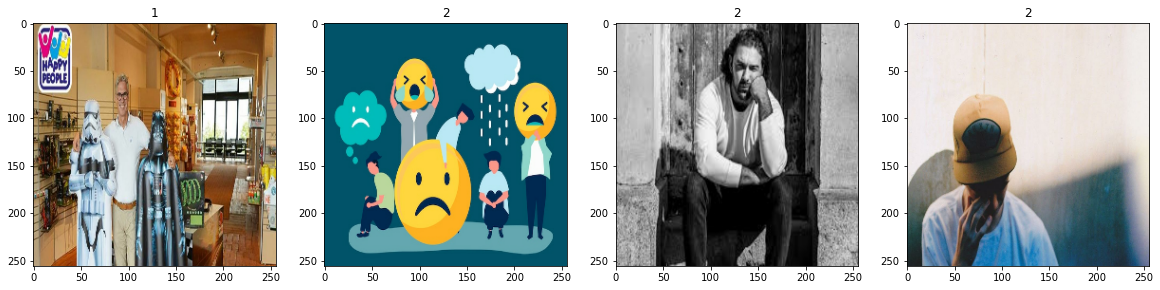

In [90]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# preprocessing step

In [91]:
batch[0].max()

255.0

In [92]:
data = data.map(lambda x,y: (x/255,y)) #x rep our images and y reps our labels

In [93]:
scaled_iterator = data.as_numpy_iterator()

In [94]:
batch = scaled_iterator.next()

In [95]:
batch[0].max()

1.0

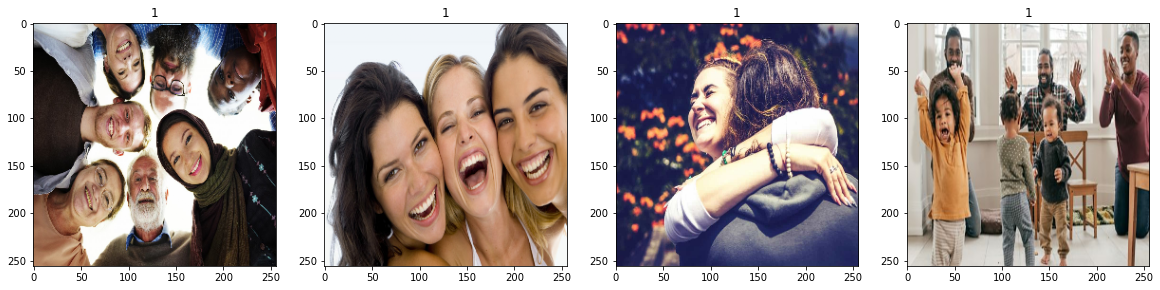

In [96]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

# Split data

In [97]:
len(data)

6

In [98]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

In [99]:
val_size+test_size+train_size

7

In [100]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# Deep Learning Model

In [101]:
from tensorflow.keras.models import Sequential # models flow from input to output
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [121]:
model = Sequential()

In [122]:
# adding a convolution layer
model.add(Conv2D(16, (3,3), 1, activation = 'relu', input_shape = (256,256,3))) 
model.add(MaxPooling2D()) # take the max value,reduce img data

model.add(Conv2D(32, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D()) 

model.add(Conv2D(16, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D()) 

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [123]:
model.compile('adam',loss=tf.losses.BinaryCrossentropy(),metrics =['accuracy'])

In [124]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 30, 30, 16)      

# Train

In [125]:
logdir='logs'

In [126]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [127]:
hist = model.fit(train, epochs=20, validation_data = val, callbacks=[tensorboard_callback])

Epoch 1/20
4/4 [==============================] - 9s 2s/step - loss: -9.1417 - accuracy: 0.3828 - val_loss: -46.8436 - val_accuracy: 0.4545
Epoch 2/20
4/4 [==============================] - 8s 2s/step - loss: -82.7789 - accuracy: 0.5156 - val_loss: -148.6051 - val_accuracy: 0.5758
Epoch 3/20
4/4 [==============================] - 7s 2s/step - loss: -333.6717 - accuracy: 0.4844 - val_loss: -582.6527 - val_accuracy: 0.5455
Epoch 4/20
4/4 [==============================] - 8s 2s/step - loss: -989.4932 - accuracy: 0.5000 - val_loss: -2226.0972 - val_accuracy: 0.4242
Epoch 5/20
4/4 [==============================] - 7s 2s/step - loss: -2634.5684 - accuracy: 0.4922 - val_loss: -3511.0212 - val_accuracy: 0.5758
Epoch 6/20
4/4 [==============================] - 8s 2s/step - loss: -6159.6338 - accuracy: 0.5000 - val_loss: -7497.2944 - val_accuracy: 0.5758
Epoch 7/20
4/4 [==============================] - 8s 2s/step - loss: -14559.2422 - accuracy: 0.4922 - val_loss: -20818.2012 - val_accuracy: 0

In [128]:
hist.history

{'loss': [-9.141716003417969,
  -82.77891540527344,
  -333.67169189453125,
  -989.4932250976562,
  -2634.568359375,
  -6159.6337890625,
  -14559.2421875,
  -29804.166015625,
  -55182.9765625,
  -110335.328125,
  -194153.453125,
  -342356.53125,
  -580583.0,
  -839643.875,
  -1539010.25,
  -2338254.0,
  -3758437.0,
  -5290339.0,
  -7543480.0,
  -11743679.0],
 'accuracy': [0.3828125,
  0.515625,
  0.484375,
  0.5,
  0.4921875,
  0.5,
  0.4921875,
  0.515625,
  0.5078125,
  0.515625,
  0.53125,
  0.5234375,
  0.5,
  0.5546875,
  0.5078125,
  0.5078125,
  0.46875,
  0.484375,
  0.5,
  0.4921875],
 'val_loss': [-46.843624114990234,
  -148.60508728027344,
  -582.6527099609375,
  -2226.09716796875,
  -3511.021240234375,
  -7497.29443359375,
  -20818.201171875,
  -38056.3046875,
  -72568.140625,
  -141687.09375,
  -346871.03125,
  -335963.15625,
  -709478.5625,
  -1793788.125,
  -1950705.625,
  -2225284.0,
  -4467671.0,
  -7469831.5,
  -11797367.0,
  -14725068.0],
 'val_accuracy': [0.454545468

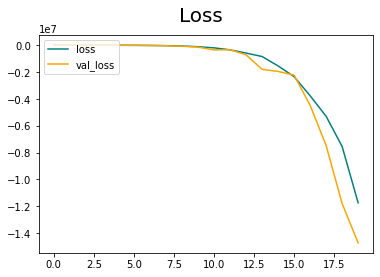

In [129]:
# plot performance
fig = plt.figure()
plt.plot(hist.history['loss'],color ='teal',label = 'loss')
plt.plot(hist.history['val_loss'], color= 'orange', label='val_loss')
fig.suptitle('Loss',fontsize=20)
plt.legend(loc='upper left')
plt.show()

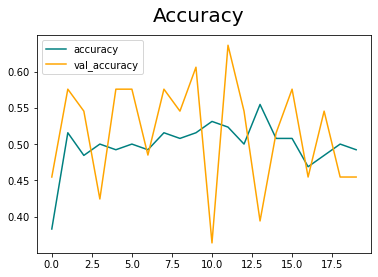

In [130]:
# plot performance
fig = plt.figure()
plt.plot(hist.history['accuracy'],color ='teal',label = 'accuracy')
plt.plot(hist.history['val_accuracy'], color= 'orange', label='val_accuracy')
fig.suptitle('Accuracy',fontsize=20)
plt.legend(loc='upper left')
plt.show()

In [112]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy



In [131]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [132]:
for batch in test.as_numpy_iterator():
    X,y = batch
    yhat = model.predict(X)
    pre.update_state(y,yhat)
    re.update_state(y,yhat)
    acc.update_state(y,yhat)

In [133]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.0, Recall:0.0, Accuracy: 0.0


# Test

<function matplotlib.pyplot.show(close=None, block=None)>

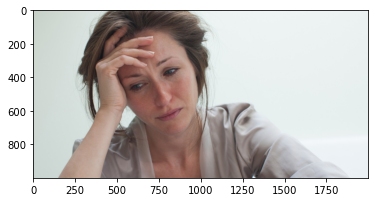

In [115]:
img = cv2.imread('sadtest.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show

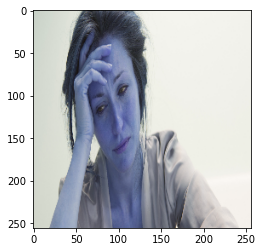

In [116]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [117]:
np.expand_dims(resize,0).shape

(1, 256, 256, 3)

In [118]:
yhat = model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 0s 207ms/step


In [119]:
yhat

array([[1.]], dtype=float32)

In [120]:
if yhat <= 1.0:
    print(f'Predicted class is happy')
else:
    print(f'Predicted class is sad!!')

Predicted class is happy
